# 1.0 Libraries & Set up

## In this section we import necessary libraries and apply plotting settings to the entire notebook

In [1]:
import os
os.chdir('../') # insures use of models folder as python module 
# Any figures saved or data pickled in the current working 
# directly will be saved up one folder from here.
import pybamm
import models
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] =  18.0
plt.rcParams['text.usetex'] = True

# 1.1 Single Layer Cell held at 30 degrees C

## 1.1.1 Initial conditions and basic parameters

### Parameter values and initial values as discussed in Cornish & Marinescu (2021) regarding equations (8), (9a), and (9b).

In [13]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T = 298
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star = 1e-6

# dissolution rate
kp = 5000

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha_30 = .43

# Initial value of S1 anion at start of charge
S1_initial_cha_30 = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_30 = S2_func(S1_initial_cha_30)

# Initial charge value of S2
S4_initial_cha_30 = S4_func(S2_initial_cha_30)

# Initial charge value of S2
S8_initial_cha_30 = S8_func(S4_initial_cha_30)

# Initial high plateau potential 
EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)

# Initial high plateau over-potential
eta_H = V_initial_cha - EH

# Initial high plateau current
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))

# Initial middle plateau potential
EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)

# Initial middle plateau over-potentia
eta_M = V_initial_cha - EM

# Initial middle plateau current
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))

# Initial low plateau potential
EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)

# Initial low plateau over-potentia
eta_L = V_initial_cha - EL

# Initial low plateau current
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_30))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_30))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_30))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_30))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_30))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H))
print('The initial charge value of the high plateau current is {} A'.format(iH))
print('The initial charge value of the middle plateau potential is {} V'.format(EM))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M))
print('The initial charge value of the middle plateau current is {} A'.format(iM))
print('The initial charge value of the low plateau potential is {} V'.format(EL))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L))
print('The initial charge value of the low plateau current is {} A'.format(iL))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.013113145894720814 g
The initial charge value of S4 anion is 6.38122975361841e-18 g
The initial charge value of S8 anion is 4.5372721447883005e-64 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.013961038961039 V
The initial charge value of the high plateau over-potential is -0.013961038961038952 V
The initial charge value of the high plateau current is 2.6419507316074737 A
The initial charge value of the middle plateau potential is 2.0133116883116884 V
The initial charge value of the middle plateau over-potential is -0.013311688311688386 V
The initial charge value of the middle plateau current is 2.516265023417388 A
The initial charge value of the low plateau potential is 1.9966403683223917 V
The initial charge value of the low plateau over-potential is 0.0033596316776083324 V
The 

## 1.1.2 Fit 30 Degree Cell Charge Voltage 

In [3]:
# Instantiate the model
model_30 = models.Cornish2021()

# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_30,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_30,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_30,
        "Initial Condition for S ion [g]" : S1_initial_cha_30,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)

# Instantiate simulation object 
sim_30_cha1 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_30_cha1.solve([0,time_in_seconds]);


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

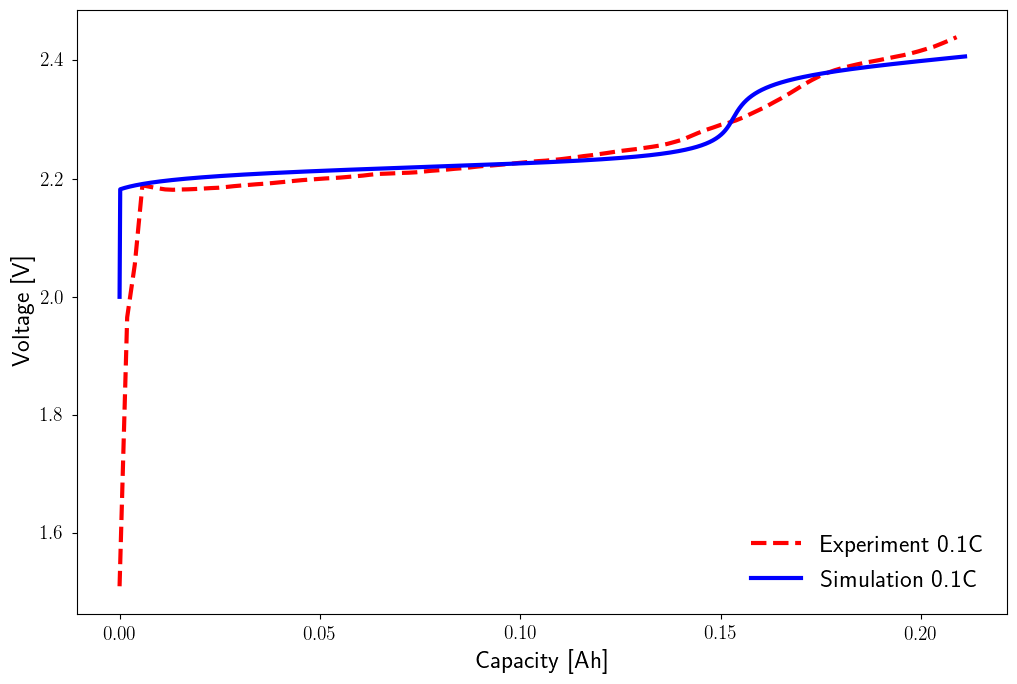

In [4]:
index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t < 36001])

capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.3 Fit the Charge Resistance

0.019024079672502223
0.22969700127270906


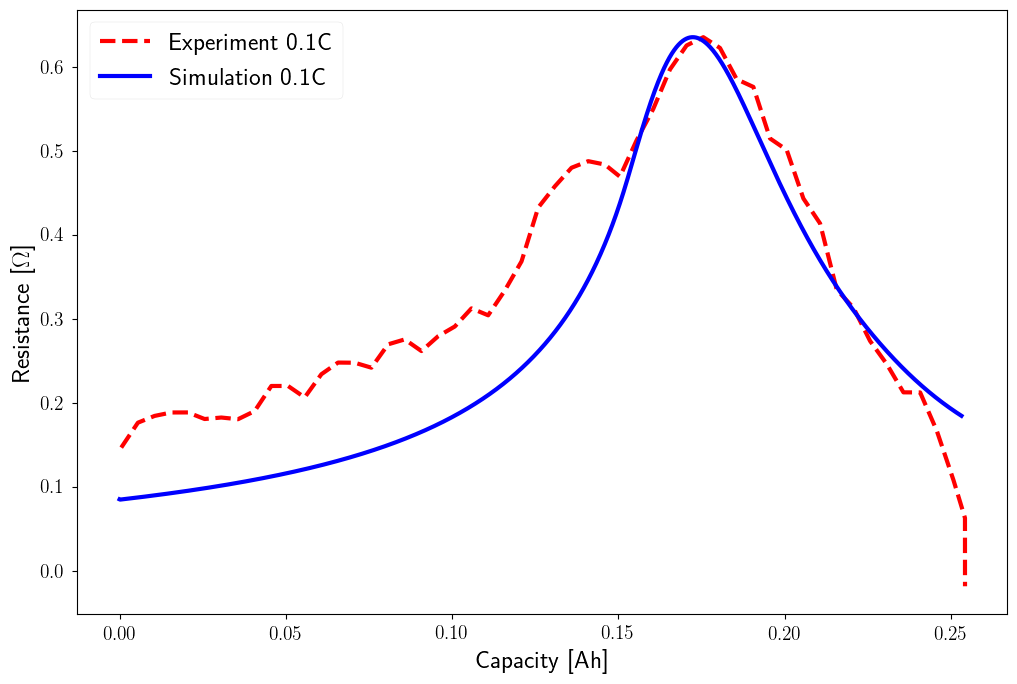

In [29]:
capacity_30 = .0211*sim_30_cha1.solution.t/3600
S4 = sim_30_cha1.solution['S4 [g]'].entries
S2 = sim_30_cha1.solution['S2 [g]'].entries
S1 = sim_30_cha1.solution['S [g]'].entries
Li_30 = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
plt.plot(res_charge_data['30'][0],res_charge_data['30'][1],linestyle='--')

beta1_30 = max(Li_30)*1.15
R_30 = 1/(beta1_30-Li_30)
alpha1_30 = max(res_charge_data['30'][1])/max(R_30)
R_30 *= alpha1_30

print(alpha1_30)
print(beta1_30)

plt.plot(capacity_30,R_30)


plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

## 1.1.4 Fit The Discharge Voltage Curve

In [6]:
loc = index_30
S1_initial = sim_30_cha1.solution['S [g]'].entries[loc]
S2_initial = sim_30_cha1.solution['S2 [g]'].entries[loc]
S4_initial = sim_30_cha1.solution['S4 [g]'].entries[loc]
S8_initial = sim_30_cha1.solution['S8 [g]'].entries[loc]
Sp_initial = sim_30_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_30_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)

0.0009128054311124569
0.15946155364017017
0.27618344094501446
6.073008769350597e-10
0.007555345271110076
2.4066183465793545


In [7]:
model_30_dis1 = models.Cornish2021()

param_30_dis1 = model_30_dis1.default_parameter_values
param_30_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 60,
        }
)


sim_30_dis1 = pybamm.Simulation(
    model_30_dis1,
    parameter_values = param_30_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time = 0
time_in_seconds = 18400#3600*6
sim_30_dis1.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_30_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_30_dis1.step(.1)
            time += .1
        except:
            try:
                sim.step(0.01)
                time += 0.01
            except:
                break
                
while time < time_in_seconds:
    try:
        sim_30_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_30_dis1.step(.1)
            time += .1
        except:
            try:
                sim_30_dis1.step(0.0001)
                time += 0.0001
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2864.35 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2882.2 and h 










 done


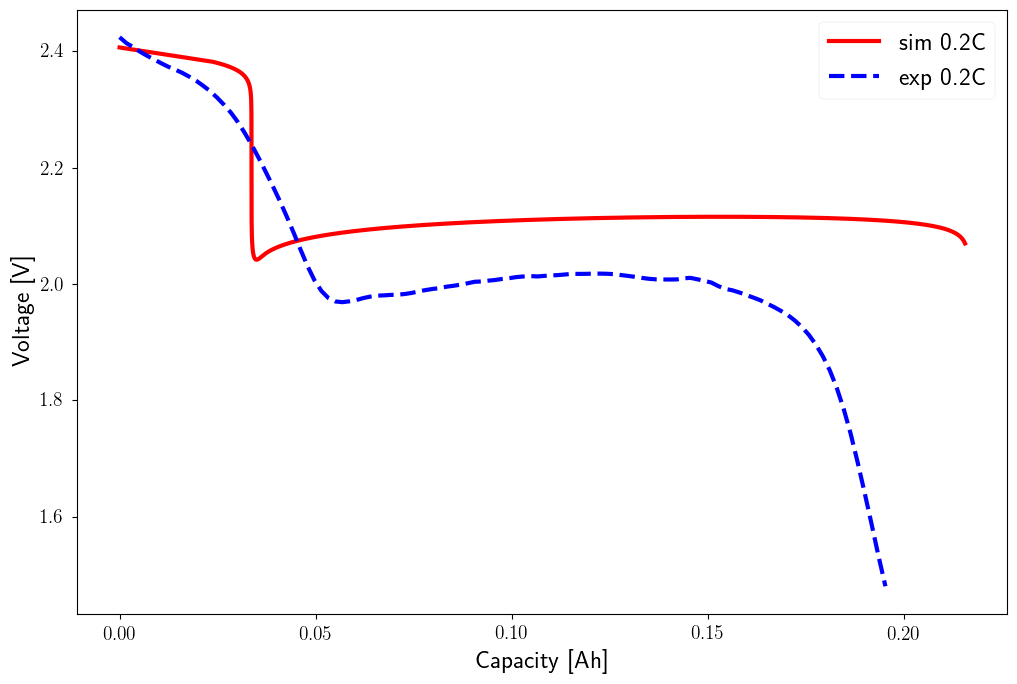

In [8]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

# 1.2 The 40 degree Cell

In [41]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T = 303.15 + 10
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# Exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star = 1e-6

# dissolution rate
kp = 15000

# Initial value of S1 anion at start of charge
S1_initial_cha_40 = 5e-4

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_40 = S2_func(S1_initial_cha_40)

# Initial charge value of S2
S4_initial_cha_40 = S4_func(S2_initial_cha_40)

# Initial charge value of S2
S8_initial_cha_40 = S8_func(S4_initial_cha_40)

# Initial value of Precipitated sulfur at start of charge
# mass conservation across cells
Sp_initial_cha_40 = (S8_initial_cha_30 + 
                     S4_initial_cha_30 + 
                     S2_initial_cha_30 + 
                     S1_initial_cha_30 + 
                     Sp_initial_cha_30) - (S8_initial_cha_40 +
                                          S4_initial_cha_40 + 
                                          S2_initial_cha_40 + 
                                          S1_initial_cha_40)

# Initial high plateau potential 
EH_40 = EH0 + (R*T)*np.log(f_h*(S8_initial_cha_40**(1/4))/(S4_initial_cha_40**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_40 = V_initial_cha - EH_40

# Initial high plateau current
iH_40 = -2*ih0*ar*np.sinh(F*eta_H_40/(2*R*T))

# Initial middle plateau potential
EM_40 = EM0 + (R*T)*np.log(f_m*(S4_initial_cha_40**(1/2))/S2_initial_cha_40)/(F)

# Initial middle plateau over-potentia
eta_M_40 = V_initial_cha - EM_40

# Initial middle plateau current
iM_40 = -2*im0*ar*np.sinh(F*eta_M_40/(2*R*T))

# Initial low plateau potential
EL_40 = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha_40**(1/2))/S1_initial_cha_40)

# Initial low plateau over-potentia
eta_L_40 = V_initial_cha - EL_40

# Initial low plateau current
iL_40 = -2*il0*ar*np.sinh(F*eta_L_40/(2*R*T))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_40))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_40))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_40))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_40))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_40))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_40))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_40))
print('The initial charge value of the high plateau current is {} A'.format(iH_40))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_40))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_40))
print('The initial charge value of the middle plateau current is {} A'.format(iM_40))
print('The initial charge value of the low plateau potential is {} V'.format(EL_40))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_40))
print('The initial charge value of the low plateau current is {} A'.format(iL_40))

The initial charge value of precipitated sulfur is 0.44136408473403826 g
The initial charge value of S1 anion is 0.0005 g
The initial charge value of S2 anion is 0.0022490611606826006 g
The initial charge value of S4 anion is 8.79914013972896e-19 g
The initial charge value of S8 anion is 2.204037630370135e-64 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.9998813829509319 V
The initial charge value of the low plateau over-potential is 0.00011861704906812598 V
The initial charge value of the low plateau current is -0.021099999999991376 A


In [42]:
# Instantiate the model
model_40 = models.Cornish2021()

# Obtain model parameter dictionary
param_40 = model_40.default_parameter_values

# Update the parameters for charge
param_40.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_40,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_40,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_40,
        "Initial Condition for S ion [g]" : S1_initial_cha_40,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_40,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp,
        'Reference Temperature [K]': T
        }
)

# Instantiate simulation object 
sim_40_cha1 = pybamm.Simulation(
    model_40,
    parameter_values = param_40,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time = 0
while time < 100:
    sim_40_cha1.step(0.1)
    time += 0.1
    
time_in_seconds = int(3600*(0.25/0.0211))#.67*7000#16950#3600*hours
while time < time_in_seconds:
    if round(time) % 1000 == 0 :
           print('\n\n\n\n' + str(100*time/time_in_seconds) + '\n\n\n\n')
    try:
        sim_40_cha1.step(1)
        time +=1
    except:
        break
        
        
print('\n\n\n\n\n\n\n\n\n done')
'''
# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_40_cha1.solve([0,time_in_seconds]);
'''

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





2.344680452009187








4.689126459417636








7.033572466826087








9.378018474234535








11.722464481642985








14.066910489051434








16.411356496459884








18.755802503868335








21.10024851127678








23.444694518685232








25.78914052609368








28.13358653350213








30.478032540910576








32.822478548319026








35.166924555727476








37.51137056313593








39.85581657054438








42.20026257795283








44.54470858536127








46.88915459276972








49.23360060017818








51.57804660758663








53.92249261499508








56.26693862240353








58.61138462981197








60.95583063722042








63.30027664462887








65.64472265203733








67.98916865944577








70.33361466685422








72.67806067426267








75.02250668167112








77.36695268907957








79.71139869648802








82.05584470389647








84.40029071130492








86.74473671871337








89.08918272612182










'\n# Define the time cut-off for charging in second\ntime_in_seconds = 1.2*int(3600/0.1)\n\n# Simulate the model \nsim_40_cha1.solve([0,time_in_seconds]);\n'

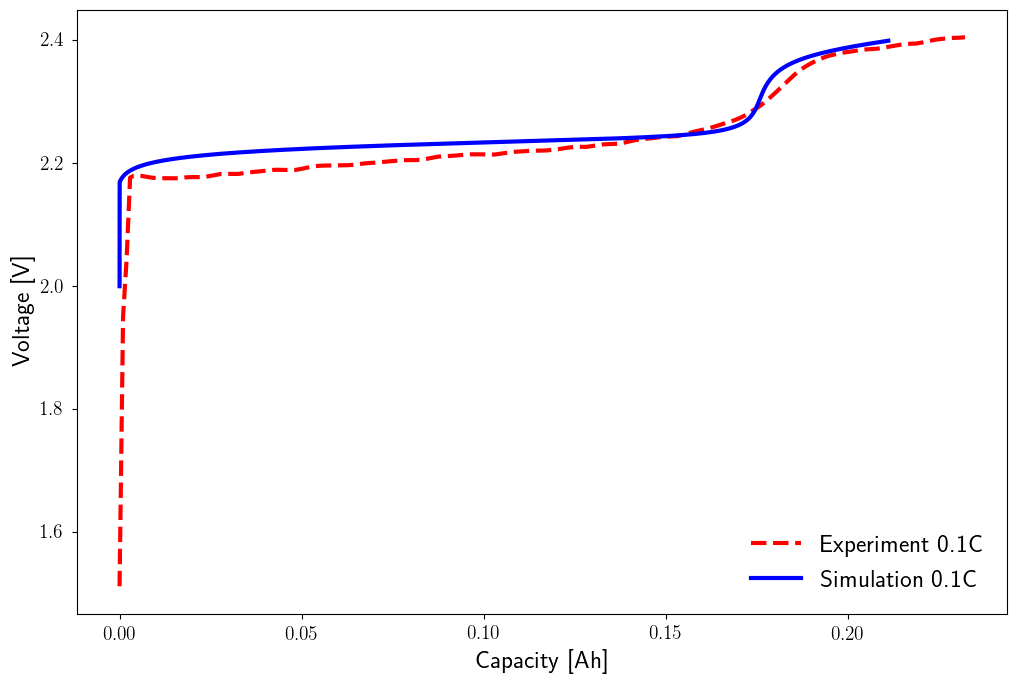

In [43]:
index_40 = len(sim_40_cha1.solution.t[sim_40_cha1.solution.t < 36001])

capacity = abs(I)*sim_40_cha1.solution.t[:index]/3600
voltage = sim_40_cha1.solution['Terminal voltage [V]'].entries[:index]

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--')

plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

0.027077953683727864
0.2680025746096128


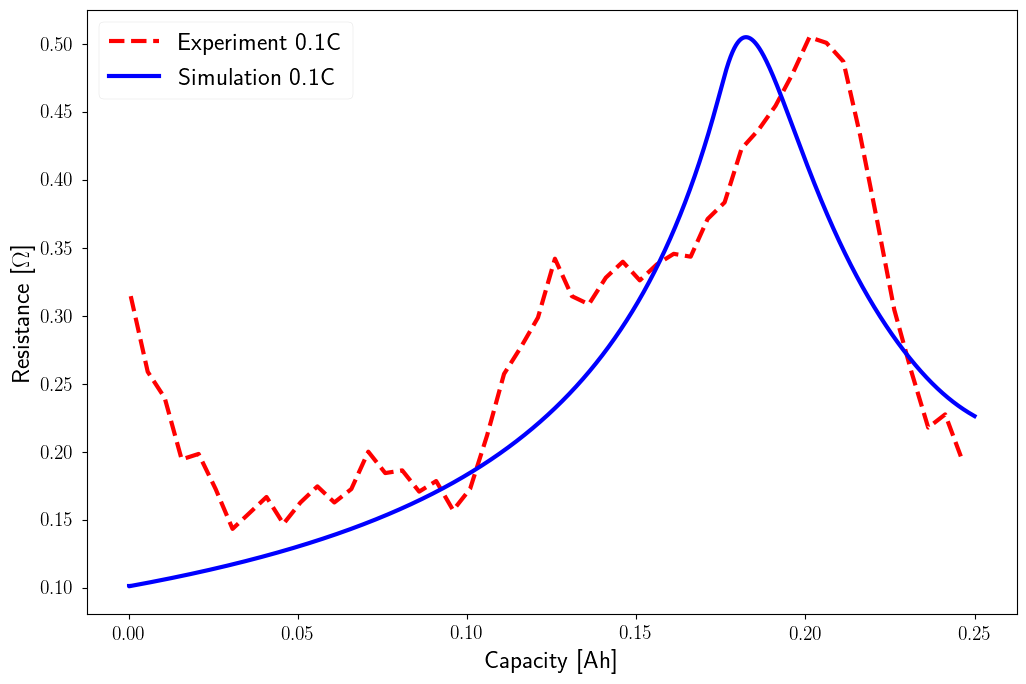

In [51]:
capacity_40 = .0211*sim_40_cha1.solution.t/3600
S4 = sim_40_cha1.solution['S4 [g]'].entries
S2 = sim_40_cha1.solution['S2 [g]'].entries
S1 = sim_40_cha1.solution['S [g]'].entries
Li_40 = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
quick_index = len(res_charge_data['40'][0][res_charge_data['40'][0]< .25])
plt.plot(res_charge_data['40'][0][:quick_index],res_charge_data['40'][1][:quick_index],linestyle='--')

max_Li_40 = max(Li_40)
max_R_40 = max(res_charge_data['40'][1])
alpha1_40 = 0.25*max_Li_40*max_R_40
beta1_40 = 1.25*max_Li_40
R_40 = alpha1_40/(beta1_40 - Li_40)



print(alpha1_40)
print(beta1_40)

plt.plot(capacity_40,R_40)


plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

In [30]:
loc = index_40
S1_initial_40 = sim_40_cha1.solution['S [g]'].entries[loc]
S2_initial_40 = sim_40_cha1.solution['S2 [g]'].entries[loc]
S4_initial_40 = sim_40_cha1.solution['S4 [g]'].entries[loc]
S8_initial_40 = sim_40_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_40 = sim_40_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_40 = sim_40_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_40)
print(S4_initial_40)
print(S2_initial_40)
print(S1_initial_40)
print(Sp_initial_40)
print(V_initial_40)

NameError: name 'index_40' is not defined

In [ ]:
model_40_dis1 = models.Cornish2021()

param_40_dis1 = model_40_dis1.default_parameter_values
param_40_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_40,
        "Initial Condition for S8 ion [g]" : S8_initial_40,
        "Initial Condition for S4 ion [g]" : S4_initial_40,
        "Initial Condition for S2 ion [g]" : S2_initial_40,
        "Initial Condition for S ion [g]" : S1_initial_40,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_40,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 60,
        }
)


sim_40_dis1 = pybamm.Simulation(
    model_40_dis1,
    parameter_values = param_40_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time = 0
time_in_seconds = 18400#3600*6
sim_40_dis1.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_40_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_40_dis1.step(.1)
            time += .1
        except:
            try:
                sim_40.step(0.01)
                time += 0.01
            except:
                break
                
while time < time_in_seconds:
    try:
        sim_40_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_40_dis1.step(.1)
            time += .1
        except:
            try:
                sim_40_dis1.step(0.0001)
                time += 0.0001
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')

# 1.3 The 20 degree Cell

In [ ]:
# Instantiate the model
model_20 = models.Cornish2021()

# Obtain model parameter dictionary
param_20 = model_20.default_parameter_values

# Update the parameters for charge
param_20.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)

# Instantiate simulation object 
sim_20_cha1 = pybamm.Simulation(
    model_20,
    parameter_values = param_20,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_20_cha1.solve([0,time_in_seconds]);

In [ ]:
# We ca

## The above initial state for charge is unrealistic, but mathematically tractible. 

## The end of charge state should now be more realistic.

## Now we can cycle the cell with similar conditions to the experiment.

In [ ]:
# Discharge initial condition 
V_initial_dis = sim_cha1.solution['Terminal voltage [V]'].entries[-1]
S8_initial_dis = sim_cha1.solution['S8 [g]'].entries[-1]
S4_initial_dis = sim_cha1.solution['S4 [g]'].entries[-1]
S2_initial_dis = sim_cha1.solution['S2 [g]'].entries[-1]
S1_initial_dis = sim_cha1.solution['S [g]'].entries[-1]
Sp_initial_dis = sim_cha1.solution['Precipitated Sulfur [g]'].entries[-1]

In [ ]:
# Reinstantiate the model
model = models.Cornish2021()

# Obtain and update parameter values
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": -2*I,
        "Initial Condition for Terminal Voltage [V]": V_initial_dis,
        "Initial Condition for S8 ion [g]" : S8_initial_dis,
        "Initial Condition for S4 ion [g]" : S4_initial_dis,
        "Initial Condition for S2 ion [g]" : S2_initial_dis,
        "Initial Condition for S ion [g]" : S1_initial_dis,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_dis,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        'Shuttle rate coefficient during charge [s-1]': .001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 100
        }
)



# Instantiate simulation object 
sim_dis1 = pybamm.Simulation(
    model,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time_in_seconds = 3600*6
sim_dis1.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_dis1.step(.1)
            time += .1
        except:
            try:
                sim.step(0.01)
                time += 0.01
            except:
                break
                
while time < time_in_seconds:
    try:
        sim_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_dis1.step(.1)
            time += .1
        except:
            try:
                sim_dis1.step(0.0001)
                time += 0.0001
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')

In [ ]:
capacity = abs(2*I)*sim_dis1.solution.t/3600
voltage = sim_dis1.solution['Terminal voltage [V]'].entries

plt.plot(capacity, voltage)

In [ ]:
# New charge initial condition 
loc = -10
S8_initial_cha2 = sim_dis1.solution['S8 [g]'].entries[loc]
S4_initial_cha2 = sim_dis1.solution['S4 [g]'].entries[loc]
S2_initial_cha2 = sim_dis1.solution['S2 [g]'].entries[loc]
S1_initial_cha2 = sim_dis1.solution['S [g]'].entries[loc]
Sp_initial_cha2 = sim_dis1.solution['Precipitated Sulfur [g]'].entries[loc]

In [ ]:
print(S8_initial_cha)

In [ ]:
# Reinstantiate the model
model = models.Cornish2021()

# Obtain and update parameter values
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": 1.8,
        "Initial Condition for S8 ion [g]" : S8_initial_cha2,
        "Initial Condition for S4 ion [g]" : S4_initial_cha2,
        "Initial Condition for S2 ion [g]" : S2_initial_cha2,
        "Initial Condition for S ion [g]" : S1_initial_cha2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        'Shuttle rate coefficient during charge [s-1]': .001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)



# Instantiate simulation object 
sim_cha2 = pybamm.Simulation(
    model,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time_in_seconds = 3600*10
sim_cha2.solve([0,time_in_seconds])
'''
sim_cha2.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_cha2.step(5)
        time+= 5
    except:
        try: 
            sim_cha2.step(.1)
            time += .1
        except:
            try:
                sim_cha2.step(0.01)
                time += 0.01
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')
'''

In [ ]:
charge = abs(I)*sim_cha2.solution.t/3600
voltage = sim_cha2.solution['Terminal voltage [V]'].entries

plt.plot(charge, voltage)